## Data Preprocessing


In [216]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from geopy import merge_geodata
from geopy import get_geodata
from date_pyler import applier_cwise
from date_pyler import to_date
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("data/Train.csv")
df = df.set_index("ID")

## Geodata


In [217]:
# add geodata to dataframe
geo_data = get_geodata(df.DEPSTN, df.ARRSTN)

df_geo = merge_geodata(df, geo_data, "DEPSTN")
df_geo = merge_geodata(df_geo, geo_data, "ARRSTN")

## Date data type convertion


In [218]:
# columnwise datetype conversion on dataframe
date_order = [
    ["%Y", "%m", "%d", "%H", "%M", "%S"],
    ["%Y", "%m", "%d", "%H", "%M", "%S"],
    ["%Y", "%m", "%d"],
]
applier_cwise(df_geo, ["STD", "STA", "DATOP"], to_date, orders=date_order)


df_geo["date_dep_year"] = df_geo.DATOP.dt.year.astype(int)
df_geo["date_dep_month"] = df_geo.DATOP.dt.month.astype(int)
df_geo["date_dep_day_year"] = df_geo.DATOP.dt.day_of_year.astype(int)
df_geo["date_dep_day_week"] = df_geo.DATOP.dt.day_of_week.astype(int)
df_geo["date_dep_hour"] = df_geo.STD.dt.hour.astype(int)
df_geo["date_dep_minute"] = df_geo.STD.dt.minute.astype(int)
df_geo["flight_duration"] = (
    (df_geo.STA - df_geo.STD).astype("timedelta64[m]").astype(int)
)

## FLIGHT STATUS


<AxesSubplot:xlabel='STATUS', ylabel='target'>

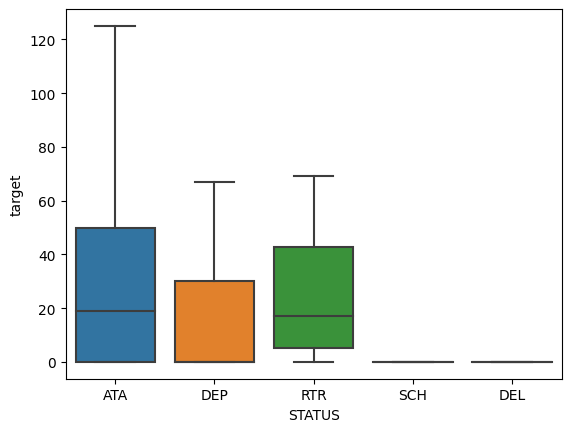

In [219]:
df_geo.STATUS.unique()


sns.boxplot(data=df_geo, x="STATUS", y="target", showfliers=False)

## FLIGHT ID


### Airlines from Flight ID


In [220]:
df_geo["exec_airline"] = df_geo.FLTID.str.split().str[0]
# df_geo[df_geo.exec_airline != df_geo.owner_airline]
df_geo

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,iata_DEPSTN,country_DEPSTN,lat_DEPSTN,lon_DEPSTN,elevation_DEPSTN,iata_ARRSTN,country_ARRSTN,lat_ARRSTN,lon_ARRSTN,elevation_ARRSTN,date_dep_year,date_dep_month,date_dep_day_year,date_dep_day_week,date_dep_hour,date_dep_minute,flight_duration,exec_airline
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,CMN,MA,33.37,-7.59,656.0,TUN,TN,36.85,10.23,22.0,2016,1,3,6,10,30,145,TU
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,MXP,IT,45.63,8.73,768.0,TUN,TN,36.85,10.23,22.0,2016,1,13,2,15,5,110,TU
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,TUN,TN,36.85,10.23,22.0,IST,TR,41.28,28.75,325.0,2016,1,16,5,4,10,155,TU
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,DJE,TN,33.88,10.78,19.0,NTE,FR,47.15,-1.61,90.0,2016,1,17,6,14,10,170,TU
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,TUN,TN,36.85,10.23,22.0,ALG,DZ,36.69,3.22,82.0,2016,1,17,6,14,30,80,TU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,TUN,TN,36.85,10.23,22.0,TUN,TN,36.85,10.23,22.0,2018,7,186,3,23,0,180,WKL
107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,DJE,TN,33.88,10.78,19.0,TUN,TN,36.85,10.23,22.0,2018,1,13,5,8,0,60,UG
107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,TUN,TN,36.85,10.23,22.0,TUN,TN,36.85,10.23,22.0,2018,11,311,2,5,0,470,SGT
107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,TUN,TN,36.85,10.23,22.0,DJE,TN,33.88,10.78,19.0,2018,1,23,1,18,0,45,UG


## Feature selection


In [221]:
features = [
    "date_dep_year",
    "date_dep_month",
    "date_dep_day_year",
    "date_dep_day_week",
    "date_dep_hour",
    "date_dep_minute",
    "flight_duration",
    "lat_DEPSTN",
    "lon_DEPSTN",
    "elevation_DEPSTN",
    "lat_ARRSTN",
    "lon_ARRSTN",
    "elevation_ARRSTN",
    "exec_airline",
    "STATUS",
]

X = df_geo[features]
y = df_geo.target



In [225]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
    
)
def OneHot(X_train = X_train, X_test = X_test, column = 'STATUS', drop="first", handle_unknown="ignore", sparse=False):
    onehot = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

    STATUS_onehot_train = onehot.fit_transform(X_train[column].to_numpy().reshape(-1, 1))
    STATUS_onehot_df_train = pd.DataFrame(STATUS_onehot_train,columns=[column + '_' + x for x in onehot.categories_[0][1:]])


    STATUS_onehot_test = onehot.transform(X_test[column].to_numpy().reshape(-1, 1))
    STATUS_onehot_df_test = pd.DataFrame(STATUS_onehot_test,columns=[column + '_' + x for x in onehot.categories_[0][1:]])



    X_train = pd.concat([X_train, STATUS_onehot_df_train.set_index(X_train.index)], axis = 1)
    X_test = pd.concat([X_test, STATUS_onehot_df_test.set_index(X_test.index)], axis = 1)

    X_train.drop(column, axis = 1, inplace = True)
    X_test.drop(column, axis = 1, inplace = True)
    return X_train, X_test

In [226]:
X_train, X_test = OneHot(X_train = X_train, X_test = X_test, column= 'STATUS')
X_train, X_test = OneHot(X_train = X_train, X_test = X_test, column = 'exec_airline')


/Users/louiskrause/neuefische/Flight_Delay_Prediction/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [228]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [231]:
y_train

73756     23.0 
3848      0.0  
41728     53.0 
7167      258.0
67152     0.0  
         ...   
54886     7.0  
76820     41.0 
103694    0.0  
860       55.0 
15795     0.0  
Name: target, Length: 91658, dtype: float64